<a href="https://colab.research.google.com/github/you444Mo/Python-Projects/blob/main/GEN_BUS_730_Final_Project_(Personal_Budget_MIP)_Zach_Moreimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Personal Budget Optimizer

In [177]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *

### Input Parameters:

In [183]:
### Input Parameters

# -----------------------
# Income and parameters
# -----------------------
Gross_Annual_Income = 95000
Gross_Monthly_Income = Gross_Annual_Income / 13
Effective_Tax_Rate = 0.25   # <-- you can change this
Health_Benefits_Monthly = 96  # (~$48 biweekly)

# -----------------------
# Categories and parameters (Adjust as Needed)
# -----------------------
mandatory_expenses = {
    "apartment_rent": 1694,
    "renters_insurance": 10.43,
    "resort_fee": 65,
    "tech_package": 105,
    "car_payment": 298,
    "car_insurance": 152,
    "valet_trash": 25,
    "phone_bill": 60,
    "gas": 120,
    "furniture_monthly_financing": 86
}

variable_expenses = {
    "food": (800, 2000),  # (min, max)
    "investing": (200, 1000),
    "student_loan": (125, 400),
    "utilities": (100, 180)
}

optional_expenses = {
    "Travel Savings Fund": 200, ### Value to save if have enough money left over
    "gym_membership": 150,
    "music_lessons": 100,
    "Sports Collectibles": 200
}

# # # Utility per dollar for each category (Utility on a scale of 1-5)
utility_mandatory = {cat: 1.0 for cat in mandatory_expenses}
utility_variable = {"food": 3.0, "investing": 2.0, "student_loan": 1.0, "utilities": 1.5}
utility_optional = {"Travel Savings Fund": 3.5, "gym_membership": 2.5, "music_lessons": 3.1, "Sports Collectibles": 3.0}

# # utility values for surplus and 401k (1-5)
utility_surplus = 1.8
utility_401k = 2.0



### Create Model:

In [184]:
# -----------------------
# Create the model
# -----------------------
model = ConcreteModel()

# # Monthly Required Surpluse
# model.surplus_min = Param(initialize=400)

# -----------------------
# Decision variables
# -----------------------
model.mandatory = Var(mandatory_expenses.keys(), within=NonNegativeReals)
model.variable = Var(variable_expenses.keys(), within=NonNegativeReals)
model.optional = Var(optional_expenses.keys(), within=NonNegativeReals)
model.y = Var(optional_expenses.keys(), within=Binary)
model._401k = Var(within=NonNegativeReals, bounds=(0, Gross_Monthly_Income * 0.20))
model.surplus = Var(within = NonNegativeReals, bounds=(0,(Gross_Monthly_Income - Health_Benefits_Monthly) * (1 - Effective_Tax_Rate))) ### Upper bound is the after tax monthly Pay

# -----------------------
# Objective: Maximize Happiness (Utility) Score For Total Dollars Spent
# -----------------------
model.obj = Objective(
    expr=sum(utility_mandatory[c] * model.mandatory[c] for c in mandatory_expenses)
        + sum(utility_variable[c] * model.variable[c] for c in variable_expenses)
        + sum(utility_optional[c] * model.optional[c] for c in optional_expenses)
        + utility_surplus * model.surplus
        + utility_401k * model._401k,
    sense=maximize
)

# -----------------------
# Constraints
# -----------------------

# 1. Mandatory expenses must meet minimum levels
def mandatory_rule(model, c):
    return model.mandatory[c] == mandatory_expenses[c]
model.mandatory_constraint = Constraint(mandatory_expenses.keys(), rule=mandatory_rule)

# 2. Variable expenses between min/max bounds
def variable_min_rule(model, c):
    return model.variable[c] >= variable_expenses[c][0]
model.variable_min_constraint = Constraint(variable_expenses.keys(), rule=variable_min_rule)

def variable_max_rule(model, c):
    return model.variable[c] <= variable_expenses[c][1]
model.variable_max_constraint = Constraint(variable_expenses.keys(), rule=variable_max_rule)

# 3. Optional expenses only allowed if selected
def optional_rule(model, c):
    return model.optional[c] <= optional_expenses[c] * model.y[c]
model.optional_constraint = Constraint(optional_expenses.keys(), rule=optional_rule)

# 4. Budget constraint — all income must be allocated
def budget_rule(model):
    taxable_income = Gross_Monthly_Income - model._401k - Health_Benefits_Monthly
    after_tax_income = taxable_income * (1 - Effective_Tax_Rate)

    total_spent = (
        sum(model.mandatory[c] for c in mandatory_expenses)
        + sum(model.variable[c] for c in variable_expenses)
        + sum(model.optional[c] for c in optional_expenses)
        + model.surplus ### This forces all unspent money to be allocated towards the surplus
    )

    # Use equality: every dollar accounted for
    return total_spent == after_tax_income
model.budget_constraint = Constraint(rule=budget_rule)


# 5. Minimum surplus rule
def surplus_rule(model):
    return model.surplus >= 400
model.surplus_constraint = Constraint(rule=surplus_rule)

# 6. Minimum 401(k) contribution (at least 4% of gross monthly income)
def min_401k_rule(model):
    return model._401k >= 0.04 * Gross_Monthly_Income
model.min_401k_constraint = Constraint(rule=min_401k_rule)

# -----------------------
# Show model
# -----------------------
model.pprint()

6 Var Declarations
    _401k : Size=1, Index=None
        Key  : Lower : Value : Upper              : Fixed : Stale : Domain
        None :     0 :  None : 1461.5384615384617 : False :  True : NonNegativeReals
    mandatory : Size=10, Index={car_insurance, resort_fee, gas, valet_trash, car_payment, apartment_rent, phone_bill, furniture_monthly_financing, renters_insurance, tech_package}
        Key                         : Lower : Value : Upper : Fixed : Stale : Domain
                     apartment_rent :     0 :  None :  None : False :  True : NonNegativeReals
                      car_insurance :     0 :  None :  None : False :  True : NonNegativeReals
                        car_payment :     0 :  None :  None : False :  True : NonNegativeReals
        furniture_monthly_financing :     0 :  None :  None : False :  True : NonNegativeReals
                                gas :     0 :  None :  None : False :  True : NonNegativeReals
                         phone_bill :     0 :  Non

### Solve Model Using CBC:

In [185]:
# -----------------------
# Solve
# -----------------------
solver = SolverFactory("cbc")
result = solver.solve(model, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /content/bin/cbc -printingOptions all -import /tmp/tmp2rxeopa9.pyomo.lp -stat=1 -solve -solu /tmp/tmp2rxeopa9.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 1 (-24) rows, 10 (-14) columns and 10 (-38) elements
Statistics for presolved model
Original problem has 4 integers (4 of which binary)


Problem has 1 rows, 10 columns (10 with objective) and 10 elements
There are 10 singletons with objective 
Column breakdown:
0 of type 0.0->inf, 4 of type 0.0->up, 0 of type lo->inf, 
6 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
1 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type 

### Model Results:

In [188]:
# -----------------------
# Display results
# -----------------------
print("\n=== RESULTS ===")
print(f"Objective (Total Utility): {value(model.obj):.2f}")
print(f"Gross Monthly Income: ${Gross_Monthly_Income:.2f}")
print(f"401(k) Contribution: ${value(model._401k):.2f} ({100 * value(model._401k) / Gross_Monthly_Income:.2f}% of gross)")
print(f"Effective After-Tax Income Used: ${(Gross_Monthly_Income - value(model._401k) - Health_Benefits_Monthly) * (1 - Effective_Tax_Rate):.2f}")
print(f"Monthly Surplus: ${value(model.surplus):.2f}\n")

print("Mandatory Expenses:")
for c in mandatory_expenses:
    print(f"  {c:30s}  ${value(model.mandatory[c]):8.2f}")

print("\nVariable Expenses:")
for c in variable_expenses:
    print(f"  {c:30s}  ${value(model.variable[c]):8.2f}")

print("\nOptional Expenses")
for c in optional_expenses:
    spent = model.optional[c]()
    Accepted = 1 if spent > 1e-3 else 0  # mark as taken only if actually spent > $0
    print(f"  {c:30s} $ {spent:7.2f}   Accepted Expense: {Accepted}")


=== RESULTS ===
Objective (Total Utility): 9952.37
Gross Monthly Income: $7307.69
401(k) Contribution: $292.31 (4.00% of gross)
Effective After-Tax Income Used: $5189.54
Monthly Surplus: $400.00

Mandatory Expenses:
  apartment_rent                  $ 1694.00
  renters_insurance               $   10.43
  resort_fee                      $   65.00
  tech_package                    $  105.00
  car_payment                     $  298.00
  car_insurance                   $  152.00
  valet_trash                     $   25.00
  phone_bill                      $   60.00
  gas                             $  120.00
  furniture_monthly_financing     $   86.00

Variable Expenses:
  food                            $ 1249.11
  investing                       $  200.00
  student_loan                    $  125.00
  utilities                       $  100.00

Optional Expenses
  Travel Savings Fund            $  200.00   Accepted Expense: 1
  gym_membership                 $    0.00   Accepted Expense: 

### Waterfall Chart of Expenses:

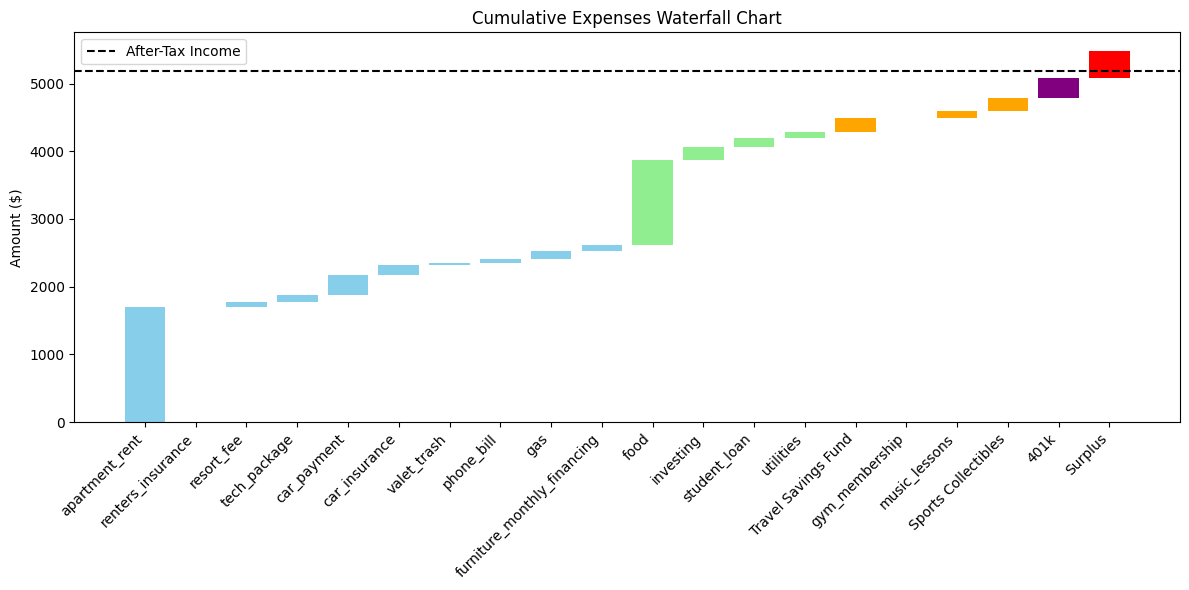

In [189]:
### Create A Waterfall Chart of Expenses
import matplotlib.pyplot as plt
import numpy as np

# -----------------------
# Gather allocations
# -----------------------
categories = []
amounts = []
colors = []

# Mandatory expenses
for c in mandatory_expenses:
    categories.append(c)
    amounts.append(value(model.mandatory[c]))
    colors.append('skyblue')

# Variable expenses
for c in variable_expenses:
    categories.append(c)
    amounts.append(value(model.variable[c]))
    colors.append('lightgreen')

# Optional expenses
for c in optional_expenses:
    categories.append(c)
    amounts.append(value(model.optional[c]))
    colors.append('orange')

# 401(k)
categories.append("401k")
amounts.append(value(model._401k))
colors.append('purple')

# Surplus
categories.append("Surplus")
amounts.append(value(model.surplus))
colors.append('red')


# -----------------------
# Compute cumulative for waterfall
# -----------------------
cumulative = np.cumsum(amounts)
start = np.insert(cumulative[:-1], 0, 0)  # starting point for each bar

# -----------------------
# Create waterfall chart
# -----------------------
fig, ax = plt.subplots(figsize=(12,6))

for i in range(len(categories)):
    ax.bar(categories[i], amounts[i], bottom=start[i], color=colors[i])

# Add net income line
net_income_after_tax = (Gross_Monthly_Income - value(model._401k) - Health_Benefits_Monthly) * (1 - Effective_Tax_Rate)
ax.axhline(net_income_after_tax, color='black', linestyle='--', label='After-Tax Income')

# Labels
ax.set_ylabel('Amount ($)')
ax.set_title('Cumulative Expenses Waterfall Chart')
ax.legend()

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
